In [100]:
# imports
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy 
import os

from pylab import *
from scipy import signal
from scipy import *
import numpy as np
from PIL import Image, ImageOps 
import cv2

Sources:  
https://www.geeksforgeeks.org/step-by-step-guide-to-using-ransac-in-opencv-using-python/  
https://en.wikipedia.org/wiki/Random_sample_consensus  
Lecture slides  

In [101]:
##############################################
### Provided code - nothing to change here ###
##############################################



"""
Harris Corner Detector
Usage: Call the function harris(filename) for corner detection
Reference   (Code adapted from):
             http://www.kaij.org/blog/?p=89
             Kai Jiang - Harris Corner Detector in Python
             
"""
# Usage: 
#harris('./path/to/image.jpg')


def harris(filename, min_distance = 10, threshold = 0.1):
    """
    filename: Path of image file
    threshold: (optional)Threshold for corner detection
    min_distance : (optional)Minimum number of pixels separating 
     corners and image boundary
     returns: filtered_coords list. index zero is row and index 1 is columns.
    """
    im = np.array(Image.open(filename).convert("L"))
    harrisim = compute_harris_response(im)
    filtered_coords = get_harris_points(harrisim,min_distance, threshold)
    plot_harris_points(im, filtered_coords)
    return filtered_coords

def gauss_derivative_kernels(size, sizey=None):
    """ returns x and y derivatives of a 2D 
        gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    y, x = mgrid[-size:size+1, -sizey:sizey+1]
    #x and y derivatives of a 2D gaussian with standard dev half of size
    # (ignore scale factor)
    gx = - x * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    gy = - y * exp(-(x**2/float((0.5*size)**2)+y**2/float((0.5*sizey)**2))) 
    return gx,gy

def gauss_kernel(size, sizey = None):
    """ Returns a normalized 2D gauss kernel array for convolutions """
    size = int(size)
    if not sizey:
        sizey = size
    else:
        sizey = int(sizey)
    x, y = mgrid[-size:size+1, -sizey:sizey+1]
    g = exp(-(x**2/float(size)+y**2/float(sizey)))
    return g / g.sum()

def compute_harris_response(im):
    """ compute the Harris corner detector response function 
        for each pixel in the image"""
    #derivatives
    gx,gy = gauss_derivative_kernels(3)
    imx = signal.convolve(im,gx, mode='same')
    imy = signal.convolve(im,gy, mode='same')
    #kernel for blurring
    gauss = gauss_kernel(3)
    #compute components of the structure tensor
    Wxx = signal.convolve(imx*imx,gauss, mode='same')
    Wxy = signal.convolve(imx*imy,gauss, mode='same')
    Wyy = signal.convolve(imy*imy,gauss, mode='same')   
    #determinant and trace
    Wdet = Wxx*Wyy - Wxy**2
    Wtr = Wxx + Wyy   
    return Wdet / Wtr

def get_harris_points(harrisim, min_distance=10, threshold=0.1):
    """ return corners from a Harris response image
        min_distance is the minimum nbr of pixels separating 
        corners and image boundary"""
    #find top corner candidates above a threshold
    corner_threshold = max(harrisim.ravel()) * threshold
    harrisim_t = (harrisim > corner_threshold) * 1    
    #get coordinates of candidates
    candidates = harrisim_t.nonzero()
    coords = [ (candidates[0][c],candidates[1][c]) for c in range(len(candidates[0]))]
    #...and their values
    candidate_values = [harrisim[c[0]][c[1]] for c in coords]    
    #sort candidates
    index = argsort(candidate_values)   
    #store allowed point locations in array
    allowed_locations = zeros(harrisim.shape)
    allowed_locations[min_distance:-min_distance,min_distance:-min_distance] = 1   
    #select the best points taking min_distance into account
    filtered_coords = []
    for i in index:
        if allowed_locations[coords[i][0]][coords[i][1]] == 1:
            filtered_coords.append(coords[i])
            allowed_locations[(coords[i][0]-min_distance):(coords[i][0]+min_distance),
                (coords[i][1]-min_distance):(coords[i][1]+min_distance)] = 0               
    return filtered_coords

def plot_harris_points(image, filtered_coords):
    """ plots corners found in image"""
    figure()
    gray()
    imshow(image)
    plot([p[1] for p in filtered_coords],[p[0] for p in filtered_coords],'r*')
    axis('off')
    show()

##############################################
### Provided code end                      ###
##############################################

In [102]:
import numpy as np
import cv2
from scipy.spatial import distance

def extract_neighborhoods(image, keypoints, window_size=16):
    half_size = window_size // 2
    descriptors = []

    for (x, y) in keypoints:
        x, y = int(x), int(y)
        neighborhood = image[max(y - half_size, 0):y + half_size, max(x - half_size, 0):x + half_size]
        
        if neighborhood.shape == (window_size, window_size):  # Ensure the patch is of the required size
            descriptor = neighborhood.flatten()
            descriptors.append(descriptor)
    
    return np.array(descriptors)

def normalize_descriptors(descriptors):
    assert descriptors.size > 0, "Empty list"
    print(f"Descriptor shape: {descriptors.shape}")

    # Compute mean and standard deviation
    mean = np.mean(descriptors, axis=1, keepdims=True)
    std_dev = np.std(descriptors, axis=1, keepdims=True)

    # Avoid division by zero
    std_dev[std_dev == 0] = 1

    # Normalize
    descriptors = (descriptors - mean) / std_dev
    return descriptors

def compute_distances(descriptors1, descriptors2, metric='sqeuclidean'):
    if metric == 'sqeuclidean':
        return distance.cdist(descriptors1, descriptors2, 'sqeuclidean')
    elif metric == 'correlation':
        return distance.cdist(descriptors1, descriptors2, 'correlation')
    else:
        raise ValueError("Unsupported metric")

In [103]:
def get_putative_matches(distances, percentile):
    # Flatten the matrix and find the N-th percentile value
    threshold = np.percentile(distances, percentile)

    # Get the indices of elements below the 25th percentile
    indices = np.argwhere(distances < threshold)

    print("Indices of lowest 25% values:\n", indices)
    return indices


In [104]:


# Example usage
left_img = np.array(Image.open('Images/left.jpg').convert("L")).astype(float)
right_img = np.array(Image.open('Images/right.jpg').convert("L")).astype(float)
keypoints1 = [(50, 50), (100, 100)]  # Example keypoints
keypoints2 = [(60, 60), (120, 120)]  # Example keypoints

descriptors1 = extract_neighborhoods(left_img, keypoints1, 2)
print("non-normalized")
print(descriptors1)
descriptors2 = extract_neighborhoods(right_img, keypoints2, 2)
#print(descriptors2)

# Normalize descriptors
descriptors1 = normalize_descriptors(descriptors1)
print("normalized descrip")
print(descriptors1)
descriptors2 = normalize_descriptors(descriptors2)
#print(descriptors2)

# Compute distances
distances = compute_distances(descriptors1, descriptors2, metric='sqeuclidean')

print("Distances:\n", distances)

putative_match_idx = get_putative_matches(distances, percentile=25)

putative_match_idx


non-normalized
[[159. 159. 159. 159.]
 [138. 156. 128. 139.]]
Descriptor shape: (2, 4)
normalized descrip
[[ 0.          0.          0.          0.        ]
 [-0.22367584  1.56573091 -1.21779071 -0.12426436]]
Descriptor shape: (2, 4)
Distances:
 [[0.         4.        ]
 [4.         2.37526566]]
Indices of lowest 25% values:
 [[0 0]]


array([[0, 0]])

In [105]:
keypoints1 = [(50, 50), (100, 100)]  # Example keypoints
keypoints2 = [(60, 60), (120, 120)]  # Example keypoints
print(descriptors1)
m = distance.cdist(descriptors1, descriptors1, 'sqeuclidean')

[[ 0.          0.          0.          0.        ]
 [-0.22367584  1.56573091 -1.21779071 -0.12426436]]


In [106]:
import numpy as np
m = np.array([[1,2,1],[4,.1,89]])

# Flatten the matrix and find the 25th percentile value
threshold = np.percentile(m, 25)

# Get the indices of elements below the 25th percentile
indices = np.argwhere(m < threshold)

print("Matrix:\n", m)
print("Indices of lowest 25% values:\n", indices)


Matrix:
 [[ 1.   2.   1. ]
 [ 4.   0.1 89. ]]
Indices of lowest 25% values:
 [[1 1]]


In [107]:
# # load each image 
# dir_path = "Images/"
# images = []     
# filenames = []
# for filename in os.listdir(dir_path):
#     if filename.endswith('.jpg'):
#         filenames.append(filename)
#         img_path = os.path.join(dir_path, filename)
#         img = Image.open(img_path)
#         #img.show()  # This will display the image
        
#         # convert images to grayscale
#         img_gs = ImageOps.grayscale(img) 
#         #img_gs.show()
#         img_gs = np.array(img_gs).astype(float)
#         img_gs = normalize(img_gs)
#         images.append(img_gs)

In [108]:
import cv2
import numpy as np

left_img = cv2.imread('Images/left.jpg', cv2.IMREAD_GRAYSCALE)
right_img = cv2.imread('Images/right.jpg', cv2.IMREAD_GRAYSCALE)

orb = cv2.ORB_create()
keypoints1, descriptors1 = orb.detectAndCompute(left_img, None)
keypoints2, descriptors2 = orb.detectAndCompute(right_img, None)

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = bf.match(descriptors1, descriptors2)
matches = sorted(matches, key=lambda x: x.distance)

print("Number of keypoints in image 1:", len(keypoints1))
print("Number of keypoints in image 2:", len(keypoints2))
print("Number of matches found:", len(matches))

src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

H, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

print("Homography Matrix (H):")
print(H)
#H = np.transpose(H)


Number of keypoints in image 1: 500
Number of keypoints in image 2: 500
Number of matches found: 151
Homography Matrix (H):
[[-3.66060281e-01 -3.88871280e+00 -1.92125668e+03]
 [-1.77949452e+01  3.53276530e+00 -2.86497462e+02]
 [-5.17765785e-02 -9.85568719e-03  1.00000000e+00]]


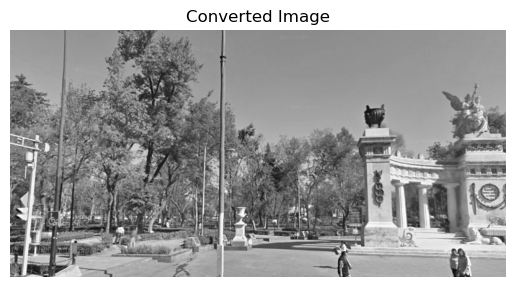

In [109]:
left_img = cv2.imread('Images/left.jpg', cv2.IMREAD_GRAYSCALE)

# Convert the NumPy array to a PIL image
image = Image.fromarray(left_img)

# Display the image using matplotlib
plt.imshow(image, cmap='gray')
plt.title('Converted Image')
plt.axis('off')  # Hide axes for better visualization
plt.show()

shape orig (398, 800), warped (398, 800)


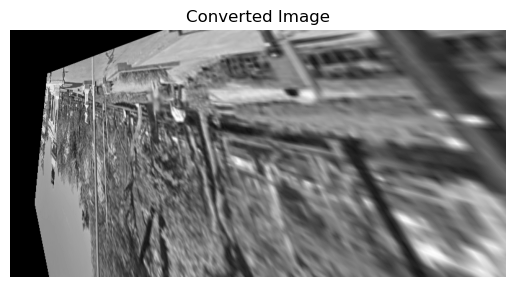

In [110]:
#might need to convert from homogenous coordinates to non-homo. (divde by w  -3rd coordinate).

from skimage.transform import ProjectiveTransform, warp
#transform image
proj_transform = ProjectiveTransform(H)
warped_img_float = warp(left_img, proj_transform)  
warped_img_int = (warped_img_float * 255).astype(np.uint8)
print(f"shape orig {left_img.shape}, warped {warped_img_int.shape}")
#cv2.imshow('Converted Image', warped_img_int)

# Convert the NumPy array to a PIL image
image = Image.fromarray(warped_img_int)

# Display the image using matplotlib
plt.imshow(image, cmap='gray')
plt.title('Converted Image')
plt.axis('off')  # Hide axes for better visualization
plt.show()

/tmp/ipykernel_999/2719819310.py:75: RuntimeWarning: divide by zero encountered in divide
  return Wdet / Wtr


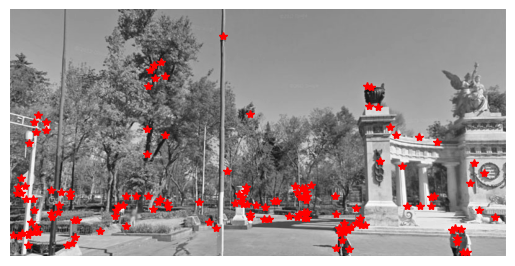

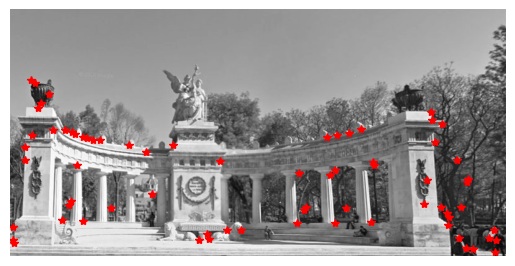

<class 'list'>
col 479, row 337
col 720, row 369
col 535, row 372
col 18, row 296
col 171, row 323
col 730, row 391
col 5, row 363
col 38, row 359
col 226, row 97
col 530, row 352
col 221, row 233
col 463, row 295
col 222, row 300
col 712, row 355
col 243, row 85
col 38, row 324
col 613, row 189
col 720, row 375
col 476, row 288
col 103, row 339
col 373, row 303
col 31, row 358
col 386, row 169
col 450, row 333
col 622, row 203
col 42, row 197
col 28, row 379
col 97, row 294
col 231, row 90
col 467, row 302
col 558, row 320
col 640, row 317
col 252, row 312
col 68, row 335
col 531, row 360
col 186, row 301
col 478, row 301
col 254, row 318
col 230, row 322
col 736, row 391
col 19, row 361
col 39, row 181
col 425, row 308
col 249, row 107
col 718, row 353
col 473, row 326
col 409, row 338
col 465, row 329
col 376, row 314
col 203, row 300
col 659, row 206
col 688, row 214
col 82, row 294
col 477, row 294
col 181, row 316
col 781, row 335
col 57, row 194
col 12, row 286
col 220, row 192


In [111]:

keypoints_left = harris('Images/left.jpg', min_distance=5, threshold=0.4)
keypoints_right = harris('Images/right.jpg', min_distance=5, threshold=0.4)
print(type(keypoints_left))
for kp in keypoints_left:
    print(f"col {kp[1]}, row {kp[0]}")

In [112]:
def get_sift_data(img):
    """
    detect the keypoints and compute their SIFT descriptors with opencv library
    """
    sift = cv2.xfeatures2d.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    return kp, des

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

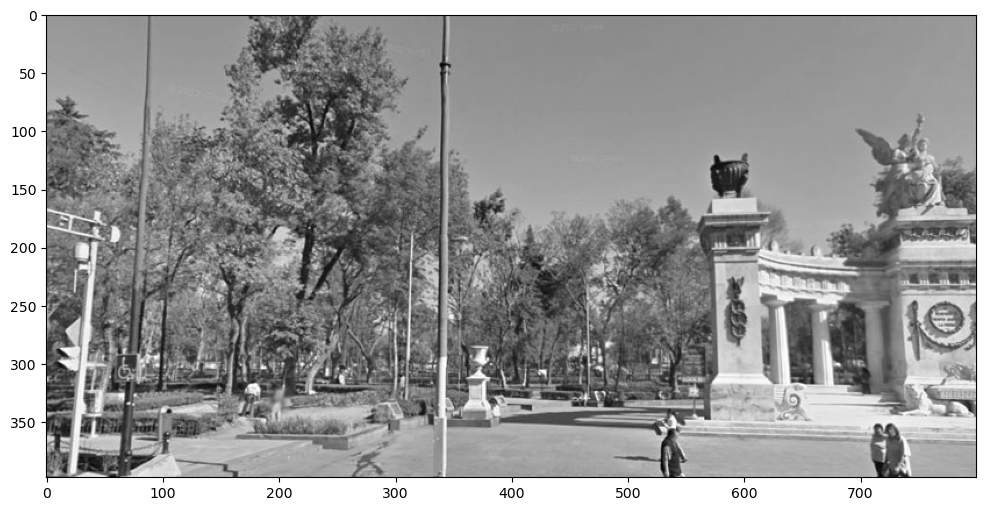

error: OpenCV(4.10.0) /croot/opencv-suite_1722029125240/work/modules/features2d/src/sift.dispatch.cpp:512: error: (-5:Bad argument) image is empty or has incorrect depth (!=CV_8U) in function 'detectAndCompute'


In [113]:
import cv2
import numpy as np
from skimage.transform import ProjectiveTransform, warp
from scipy.spatial import distance
import matplotlib.pyplot as plt

left_filename = 'Images/left.jpg'
right_filename = 'Images/right.jpg'

# Load images
img1 = cv2.imread(left_filename)
img2 = cv2.imread(right_filename)


# Convert to grayscale and float32
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY).astype(np.float32)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY).astype(np.float32)

plt.figure(figsize=(12, 8))
plt.imshow(gray1)
plt.show()

# Detect feature points
# filtered_coords1 = harris(left_filename)
# filtered_coords2 = harris(right_filename)
kp_img1, des_img1 = get_sift_data(gray1)
kp_img2, des_img2 = get_sift_data(gray2)

# Extract local neighborhoods and form descriptors
# def extract_descriptors(gray, coords, neighborhood_size=40):
#     descriptors = []
#     padded_gray = np.pad(gray, neighborhood_size//2, mode='constant')
    
#     for coord in coords:
#         x, y = coord
#         x += neighborhood_size//2
#         y += neighborhood_size//2
        
#         # Check if neighborhood is within padded image
#         if (x - neighborhood_size//2 >= 0 and x + neighborhood_size//2 + 1 < padded_gray.shape[1] and
#             y - neighborhood_size//2 >= 0 and y + neighborhood_size//2 + 1 < padded_gray.shape[0]):
#             neighborhood = padded_gray[y-neighborhood_size//2:y+neighborhood_size//2+1, 
#                                       x-neighborhood_size//2:x+neighborhood_size//2+1]
#             descriptors.append(neighborhood.flatten())
    
#     return np.array(descriptors)

# descriptors1 = extract_descriptors(gray1, filtered_coords1)
# descriptors2 = extract_descriptors(gray2, filtered_coords2)

# Normalize descriptors
# descriptors1 = (descriptors1 - np.mean(descriptors1, axis=1, keepdims=True)) / np.std(descriptors1, axis=1, keepdims=True)
# descriptors2 = (descriptors2 - np.mean(descriptors2, axis=1, keepdims=True)) / np.std(descriptors2, axis=1, keepdims=True)

# Compute pairwise descriptor distances
#distances = distance.cdist(descriptors1, descriptors2, 'euclidean')
distances = scipy.spatial.distance.cdist(des_img1, des_img2, 'sqeuclidean') 

# Select putative matches
threshold = np.percentile(distances, 1)
putative_matches = np.argwhere(distances < threshold)

# RANSAC to estimate homography
def ransac(matches, coords1, coords2, iterations=1000, threshold=5):
    best_inliers = []
    best_residual = float('inf')
    for _ in range(iterations):
        # Randomly select four matches
        indices = np.random.choice(len(matches), 4, replace=False)
        match_indices = matches[indices]
        src_pts = np.array([coords1[m[0]] for m in match_indices])
        dst_pts = np.array([coords2[m[1]] for m in match_indices])
        
        # Compute homography
        H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, threshold)
        
        # Compute residuals
        residuals = []
        inliers = []
        for match in matches:
            src_pt = np.array([coords1[match[0]]])
            dst_pt = np.array([coords2[match[1]]])
            transformed_pt = np.dot(H, np.array([src_pt[0][0], src_pt[0][1], 1]))[:2]
            residual = np.sum((transformed_pt - dst_pt[0]) ** 2)
            residuals.append(residual)
            if residual < threshold ** 2:
                inliers.append(match)
        
        # Update best solution
        if len(inliers) > len(best_inliers) or (len(inliers) == len(best_inliers) and np.mean(residuals) < best_residual):
            best_inliers = inliers
            best_residual = np.mean(residuals)
            best_H = H
    
    return best_H, best_inliers, best_residual

H, best_inliers, best_residual = ransac(putative_matches, kp_img1, kp_img2)

# Display inlier matches
def plot_inlier_matches(ax, img1, img2, inliers, coords1, coords2):
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')
    
    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')
    
    plt.scatter([c[1] for c in coords1], [c[0] for c in coords1], c='r')
    plt.scatter([coords1[m[0]][1] for m in inliers], [coords1[m[0]][0] for m in inliers], c='g')
    
    plt.subplot(122)
    plt.imshow(img2)
    plt.scatter([c[1] for c in coords2], [c[0] for c in coords2], c='r')
    plt.scatter([coords2[m[1]][1] for m in inliers], [coords2[m[1]][0] for m in inliers], c='g')
    
    plt.show()

def plot_inlier_matches(ax, img1, img2, inliers):
    """
    plot the match between two image according to the matched keypoints
    :param ax: plot handle
    :param img1: left image
    :param img2: right image
    :inliers: x,y in the first image and x,y in the second image (Nx4)
    """
    res = np.hstack([img1, img2])
    ax.set_aspect('equal')
    ax.imshow(res, cmap='gray')

    ax.plot(inliers[:,0], inliers[:,1], '+r')
    ax.plot(inliers[:,2] + img1.shape[1], inliers[:,3], '+r')
    ax.plot([inliers[:,0], inliers[:,2] + img1.shape[1]],
            [inliers[:,1], inliers[:,3]], 'r', linewidth=0.4)
    ax.axis('off')

#plot_inlier_matches(img1, img2, best_inliers, filtered_coords1, filtered_coords2)
fig, ax = plt.subplots(figsize=(20,10))
plot_inlier_matches(ax, gray1, gray2, best_inliers)

# Warp one image onto the other
# def warp_image(img1, img2, H):
#     transform = ProjectiveTransform(H)
#     warped_img1 = warp(img1, transform, output_shape=img2.shape)
#     return warped_img1

# warped_img1 = warp_image(img1, img2, best_H)

def warp_images(img1, img2, H):
    """
    Write your code to stitch images together according to the homography.
    img1 and img2 must be color images.
    """
    transform = skimage.transform.ProjectiveTransform(H)
    
    # Calculate the boundary of warped image
    h, w, _ = img1.shape
    raw = np.array([[0, 0], [0, h], [w, h], [w, 0]])
    trans = transform(raw)

    combine = np.vstack((raw, trans))
    min_dot = np.int32(combine.min(axis=0))
    max_dot = np.int32(combine.max(axis=0))
    offset_x = -min_dot[0]
    offset_y = -min_dot[1]
    print("offset is ", (offset_x, offset_y))
    T_matrix = np.array([[1, 0, offset_x], [0, 1, offset_y], [0, 0, 1]])

    match = cv2.warpPerspective(img2, T_matrix.dot(H), tuple(max_dot - min_dot))

    h1, w1, _ = match.shape
    for y in range(h):
        for x in range(w):
            if offset_x + x < w1 and offset_y + y < h1:
                if np.count_nonzero(match[offset_y + y, offset_x + x]) == 0:
                    match[offset_y + y, offset_x + x] = img1[y, x]
                else:
                    match[offset_y + y, offset_x + x] = (match[offset_y + y, offset_x + x] / 2 + img1[y, x] / 2).astype(np.uint8)
    
    return match

# Composite the two images
# def composite_images(warped_img1, img2):
#     # Find overlap region
#     overlap = np.logical_and(warped_img1 > 0, img2 > 0)
    
#     # Average pixel values in overlap region
#     composite_img = warped_img1.copy()
#     composite_img[overlap] = (warped_img1[overlap] + img2[overlap]) / 2
    
#     return composite_img

#composite_img = composite_images(warped_img1, img2)

# # Display the panorama
# plt.figure(figsize=(12, 6))
# plt.imshow(composite_img)
# plt.axis('off')
# plt.show()

# # Save the panorama
# cv2.imwrite('panorama.jpg', composite_img)           
# 

print("Warping images...")
im = warp_images(img2, img1, H)

plt.figure(figsize=(12, 8))
plt.imshow(im)
plt.show()  

In [ ]:
# imports
import numpy as np
import skimage
import cv2
import matplotlib.pyplot as plt
from scipy.spatial import distance
import scipy 
import time
import imageio
import matplotlib as plt
from scipy.spatial.distance import cdist

In [ ]:
left_filename = 'Images/left.jpg'
right_filename = 'Images/right.jpg'

SIFT = True
left = Image.open(left_filename).convert("L").convert("F")
right = Image.open(right_filename).convert("L").convert("F")
hl = get_harris_points(compute_harris_response(np.array(left)))       #588 points
hr = get_harris_points(compute_harris_response(np.array(right)))
neighbour = 8
hl = np.array(hl)
hr = np.array(hr)
ld = []
rd = []
for ly, lx in hl:
    region = left.crop((lx-neighbour, ly-neighbour, lx+neighbour, ly+neighbour))
    descriptor = np.array(region).flatten()
    ld.append(descriptor)
for ry, rx in hr:
    region = right.crop((rx-neighbour, ry-neighbour, rx+neighbour, ry+neighbour))
    descriptor = np.array(region).flatten()
    rd.append(descriptor)
left = np.array(left)
right = np.array(right)
ld = np.array(ld)                       
rd = np.array(rd)
threshold = 10000
if(SIFT):
    left = cv2.cvtColor(cv2.imread(left_filename), cv2.COLOR_RGB2GRAY)
    right = cv2.cvtColor(cv2.imread(right_filename), cv2.COLOR_RGB2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    hl, ld = sift.detectAndCompute(left, None)
    sift = cv2.xfeatures2d.SIFT_create()
    hr, rd = sift.detectAndCompute(right, None)
    ld = np.array(ld)                       
    rd = np.array(rd)
    hl = np.array(hl)
    hr = np.array(hr)
    
lmatch = []
rmatch = []
distances = scipy.spatial.distance.cdist(ld, rd, 'sqeuclidean')
for r in range(rd.shape[0]):
    for l in range(ld.shape[0]):
        if(abs(distances[l][r]) < threshold):
          #   print("r: "+str(r)+" l: "+str(l)+" distance: "+str(distances))
            if(SIFT):
                lmatch.append((hl[int(l)].pt[0], hl[int(l)].pt[1]))  
                rmatch.append((hr[int(r)].pt[0], hr[int(r)].pt[1]))        
            else:
                lmatch.append(hl[int(l)][::-1])
                rmatch.append(hr[int(r)][::-1])
lmatch = np.vstack(lmatch)
rmatch = np.vstack(rmatch)
computed_inliers = np.concatenate((lmatch, rmatch), axis=1)  

print(f"shape computed_inliers {computed_inliers.shape}")

# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, left, right, computed_inliers)
# plt.show()

iternum = 10000
inlier_threshold = 0.1
best_inliers = []
best_H = None
best_residual = -1
for i in range(iternum):
    A = []
    pick = computed_inliers[np.random.choice(computed_inliers.shape[0], 4, replace=False)]
    for j in range(4):
          x1, y1, x2, y2 = pick[j]
          A.append([0, 0, 0, x1, y1, 1, -1*y2*x1, -1*y2*y1, -1*y2])  
          A.append([x1, y1, 1, 0, 0, 0, -1*x2*x1, -1*x2*y1, -1*x2])   
    A = np.array(A)
    U, s, V = np.linalg.svd(A)
    H = V[len(V)-1].reshape(3, 3)
    H = H / H[2, 2]   
    if np.linalg.matrix_rank(H) < 3:
          continue 
    target = np.dot(H, np.column_stack((lmatch, np.ones(len(lmatch)))).T).T
    target /= target[:, 2].reshape(-1, 1)
#     residuals = np.sum((rmatch - target[:, :2]) ** 2, axis=1)
    residuals = np.linalg.norm(rmatch - target[:, :2], axis=1) ** 2
    inliers = np.where(residuals < inlier_threshold)[0]
    avg_residual = np.mean(residuals[inliers])   
    if len(inliers) > len(best_inliers):
        show_match = computed_inliers[inliers].copy()
        best_inliers = inliers.copy()
        best_H = H.copy()
        best_residual = avg_residual.copy()
        print("number of inliers: " + str(len(best_inliers)) + "\n average residual: " + str(best_residual))


# fig, ax = plt.subplots(figsize=(20,10))
# plot_inlier_matches(ax, left, right, show_match)
# plt.show()

transform = skimage.transform.ProjectiveTransform(best_H)
row, column = left.shape[:2]
corners = np.array([[0, 0],[0, row],[column, 0],[column, row]])
corners = np.vstack((transform(corners), corners))
big = np.ceil((np.max(corners, axis=0) - np.min(corners, axis=0))[::-1])
s = skimage.transform.SimilarityTransform(translation=-1*np.min(corners, axis=0))
l = skimage.transform.warp(left, s.inverse, output_shape=big, cval=-1)
r = skimage.transform.warp(left, (transform + s).inverse, output_shape=big, cval=-1)
l0 = skimage.transform.warp(left, s.inverse, output_shape=big, cval=0)
r0 = skimage.transform.warp(left, (transform + s).inverse, output_shape=big, cval=0)
mask = (l != -1.0 ).astype(int) + (r != -1.0).astype(int)
mask += (mask < 1).astype(int)
res = np.asarray(Image.fromarray((255*(l0+r0)/mask).astype('uint8'), mode='L'))
cv2.imwrite("part1.jpg", res)

[ WARN:0@213.789] global shadow_sift.hpp:13 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


KeyboardInterrupt: 